# Chest X-Ray Images classification

## 1. Introduction
Basing on image and patient data we want to classify into one or multiple classes

## 2. Data
We're working on dataset from Kaggle https://www.kaggle.com/nih-chest-xrays/data.
This NIH Chest X-ray Dataset comprises 112,120 X-ray images with disease labels from 30,805 unique patients. To create these labels, the authors used Natural Language Processing to text-mine disease classifications from the associated radiological reports. The labels are expected to be >90% accurate and suitable for weakly-supervised learning.

### Data limitations:
The image labels are NLP extracted so there could be some erroneous labels but the NLP labeling accuracy is estimated to be >90%.
Very limited numbers of disease region bounding boxes (See BBox_list_2017.csv)
Chest x-ray radiology reports are not anticipated to be publicly shared. Parties who use this public dataset are encouraged to share their “updated” image labels and/or new bounding boxes in their own studied later, maybe through manual annotation
### Class descriptions
There are 15 classes (14 diseases, and one for "No findings"). Images can be classified as "No findings" or one or more disease classes:

Atelectasis
Consolidation
Infiltration
Pneumothorax
Edema
Emphysema
Fibrosis
Effusion
Pneumonia
Pleural_thickening
Cardiomegaly
Nodule Mass
Hernia

In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [118]:
def plot_bar(x, y, title, y_label="Count", x_label=""):
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.xticks(rotation=90)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    sns.barplot(x=x, y=y, alpha=1)

In [64]:
image_paths = pd.DataFrame(glob("data/images_*/images/*.png"), columns=["path"])
image_paths["Image Index"] = image_paths["path"].apply(lambda x: x.split("/")[-1])

path           112120
Image Index    112120
dtype: int64

In [66]:
all_xray_df = pd.read_csv('data/Data_Entry_2017.csv')

In [69]:
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [104]:
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


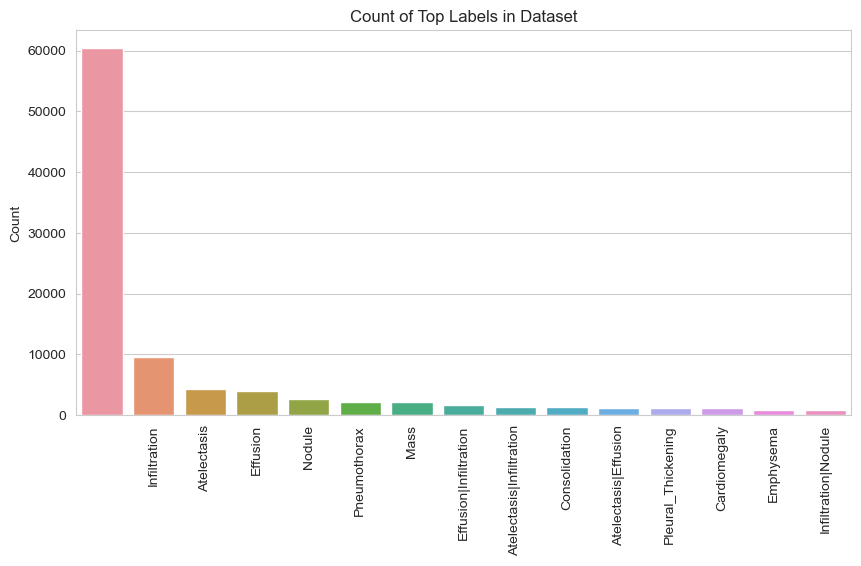

In [119]:
import seaborn as sns
multiclass_counts = all_xray_df['Finding Labels'].value_counts()
multilabel_counts = multiclass_counts[:15]

plot_bar(multilabel_counts.index, multilabel_counts.values, "Count of Top Labels in Dataset")

In [106]:
multilabel_counts.index = multilabel_counts.index.map(lambda x: x.replace('No Finding', ''))

In [107]:
from bitarray import bitarray

# Define the class labels in a sorted set
all_labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
unique_labels = all_labels.copy()

d = {label: ix for ix, label in enumerate(all_labels)}

# Column "Finding Labels" contains multiple label names separated by "|". "No Finding" means no disease.
# Define a function to convert "Finding Labels" to one-hot encoded in one hot encoded vector stored in "Disease Vector". "No Finding" is encoded as all zeros.
def convert_labels_to_vector(labels):
    # split labels by "|"
    labels = labels.split("|")
    # create a bitarray full of False with length of unique_diseases
    vector = bitarray('0'*14)
    # if "No Finding" in labels, return vector
    if "No Finding" in labels:
        return vector
    # for each label in labels, set the corresponding index in vector to 1
    for label in labels:
        vector[d[label]] = 1

    return vector

# Apply convert_labels_to_vector to "Finding Labels" column and store in "Disease Vector" column

In [108]:
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

In [109]:
all_xray_df.head() # verified

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if all_xray_df[c_label].sum() > MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)),
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])

Clean Labels (13) [('Atelectasis', 11559), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13317), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19894), ('Mass', 5782), ('Nodule', 6331), ('Pleural_Thickening', 3385), ('Pneumonia', 1431), ('Pneumothorax', 5302)]


In [ ]:
# resample the dataset to be more balanced


In [131]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.1 + number of findings
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values.astype(float)
sample_weights /= sample_weights.sum()
sample_weights

array([4.43793547e-05, 5.91724730e-05, 1.47931182e-05, ...,
       1.47931182e-05, 2.95862365e-05, 1.47931182e-05])

In [134]:
all_xray_df = all_xray_df.sample(40000, weights=sample_weights)

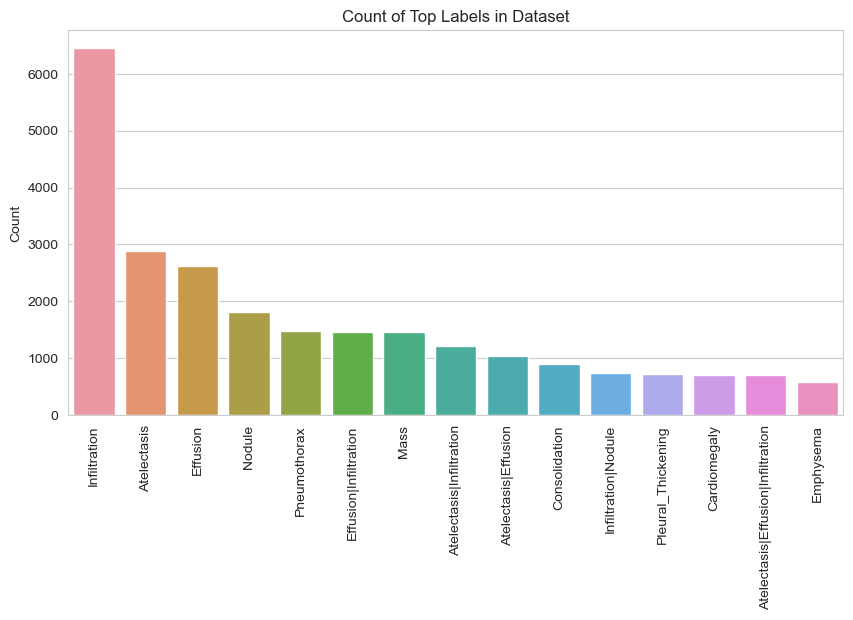

In [135]:
multilabel_counts = all_xray_df['Finding Labels'].value_counts()[:15]

plot_bar(multilabel_counts.index, multilabel_counts.values, "Count of Top Labels in Dataset")

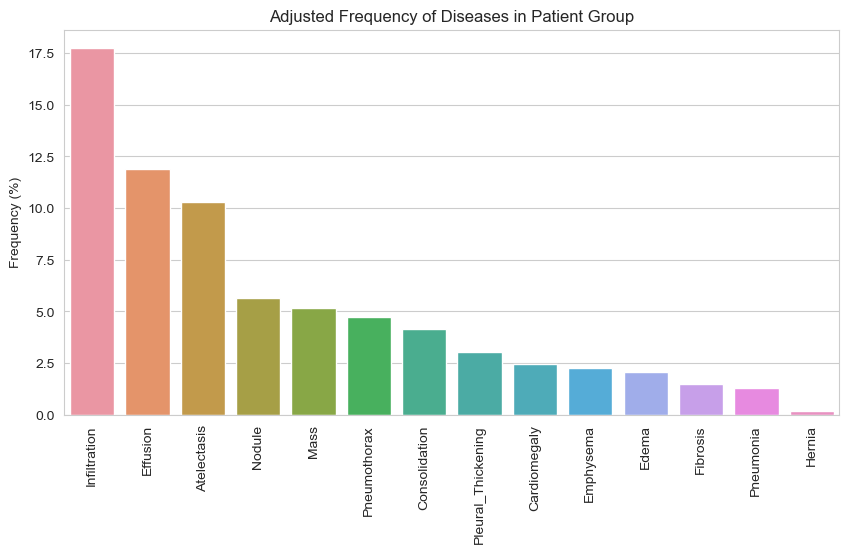

In [120]:
multilabel_counts = 100 * np.mean(all_xray_df[all_labels].values, 0)
l_value_counts = sorted(zip(all_labels, multilabel_counts), key=lambda x: x[1], reverse=True)

plot_bar([v[0] for v in l_value_counts], [v[1] for v in l_value_counts], "Adjusted Frequency of Diseases in Patient Group", y_label="Frequency (%)")

In [121]:
all_xray_df['Finding Labels']

0                   Cardiomegaly
1         Cardiomegaly|Emphysema
2          Cardiomegaly|Effusion
3                               
4                         Hernia
                   ...          
112115            Mass|Pneumonia
112116                          
112117                          
112118                          
112119                          
Name: Finding Labels, Length: 112120, dtype: object

In [19]:
all_xray_df['disease_vec'] = all_xray_df[all_labels].apply(lambda x: np.array(x.values, dtype=np.float32), 1)

In [20]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(all_xray_df,
                                      test_size = 0.25,
                                      random_state = 2018,
                                      stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))

print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 30000 validation 10000


In [21]:
os.getcwd()

'/Users/blazej.przybyszewski/Desktop/src/chest-xray-classification'

In [22]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (128, 128)
BATCH_SIZE = 30
VALID_BATCH_SIZE = 250
TEST_BATCH_SIZE = 1000
STEPS_PER_EPOCH = 100
COLOR_CHANNELS = 1

# this is the augmentation configuration we will use for training
# convert to float32, rescale to [0,1] and normalize to mean 0 and std 1

core_idg = ImageDataGenerator(samplewise_center=True,
                              samplewise_std_normalization=True,
                              horizontal_flip = True,
                              vertical_flip = False,
                              height_shift_range= 0.05,
                              width_shift_range=0.1,
                              rotation_range=5,
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [23]:
import tensorflow as tf
# define cmap that converts color_mode to channel count
clr_mode = {1: 'grayscale', 3: 'rgb'}

# def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, target_size=(128, 128), color_mode='rgb', batch_size=32, shuffle=False, seed=None):
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, target_size=IMG_SIZE, color_channels=COLOR_CHANNELS, batch_size=BATCH_SIZE, seed=None):
    df_gen = img_data_gen.flow_from_dataframe(
        in_df, directory=os.getcwd(),
        x_col=path_col,
        y_col=y_col,
        class_mode='raw',
        batch_size=batch_size,
        target_size=target_size,
        color_mode=clr_mode[color_channels],
        shuffle=True,
        repeat=True,
        seed=seed
    )

    # Convert to a tf.data.Dataset object
    def data_generator():
        while True:
            x, y = next(df_gen)
            yield x, np.vstack(y)


    train_ds = tf.data.Dataset.from_generator(data_generator,
                                              output_signature=(
                                                    tf.TensorSpec(shape=(batch_size, *target_size, color_channels), dtype=tf.float32),
                                                    tf.TensorSpec(shape=(batch_size, len(all_labels)), dtype=tf.float32)))

    return train_ds


In [24]:
train_ds = flow_from_dataframe(core_idg, train_df,
                               path_col = 'path',
                               y_col = 'disease_vec',
                               target_size = IMG_SIZE,
                               color_channels=COLOR_CHANNELS,
                               batch_size = BATCH_SIZE)
valid_ds = flow_from_dataframe(core_idg, valid_df,
                               path_col = 'path',
                               y_col = 'disease_vec',
                               target_size = IMG_SIZE,
                               color_channels=COLOR_CHANNELS,
                               batch_size = VALID_BATCH_SIZE) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
test_ds = flow_from_dataframe(core_idg, valid_df,
                              path_col = 'path',
                              y_col = 'disease_vec',
                              target_size = IMG_SIZE,
                              color_channels=COLOR_CHANNELS,
                              batch_size = TEST_BATCH_SIZE) # one big batch

test_X, test_y = next(iter(test_ds))

Found 30000 validated image filenames.
Metal device set to: Apple M1 Pro
Found 10000 validated image filenames.
Found 10000 validated image filenames.


2023-02-19 13:41:27.630870: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-19 13:41:27.631317: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-19 13:41:27.829578: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [25]:
test_X.shape, test_y.shape, STEPS_PER_EPOCH

(TensorShape([1000, 128, 128, 1]), TensorShape([1000, 13]), 100)

In [26]:
## Creating model
import tensorflow_hub as hub

from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Sequential

base_mobilenet_model = MobileNet(input_shape =  (*IMG_SIZE, COLOR_CHANNELS),
                                 include_top = False, weights = None)
# model_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
# resnet = hub.KerasLayer(model_url, input_shape=(*IMG_SIZE, COLOR_CHANNELS), trainable=False)
multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
# multi_disease_model.add(resnet)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512, activation = 'relu'))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = tf.keras.optimizers.legacy.Adam(), loss = 'binary_crossentropy',
                            metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 13)                6

In [27]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 2, verbose = 1,
                        min_delta = 1e-4, min_lr = 1e-6, mode = 'min', cooldown=1)

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=3)
callbacks_list = [rlr, checkpoint, early]

In [28]:
multi_disease_model.fit(train_ds,
                        steps_per_epoch=STEPS_PER_EPOCH,
                        validation_data = (test_X, test_y),
                        epochs = 1,
                        callbacks = callbacks_list)

2023-02-19 13:41:50.046744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 0.3668 - binary_accuracy: 0.8632 - mae: 0.2015

2023-02-19 13:42:21.296131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.39565, saving model to xray_class_weights.best.hdf5
100/100 [==============================] - 33s 313ms/step - loss: 0.3668 - binary_accuracy: 0.8632 - mae: 0.2015 - val_loss: 0.3956 - val_binary_accuracy: 0.8765 - val_mae: 0.2939 - lr: 0.0010


In [29]:
for c_label, s_count in zip(all_labels, 100*np.mean(test_y,axis=0)):
    print('%s: %2.2f%%' % (c_label, s_count))

Atelectasis: 22.70%
Cardiomegaly: 5.90%
Consolidation: 10.30%
Edema: 5.20%
Effusion: 27.20%
Emphysema: 4.30%
Fibrosis: 3.70%
Infiltration: 37.50%
Mass: 13.00%
Nodule: 11.40%
Pleural_Thickening: 4.80%
Pneumonia: 3.60%
Pneumothorax: 11.00%


In [30]:
pred_y = multi_disease_model.predict(test_X, batch_size = 1024, verbose = True)

2023-02-19 13:42:22.609316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 484ms/step


In [31]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# get np array of test_y
test_Y = test_y.numpy()

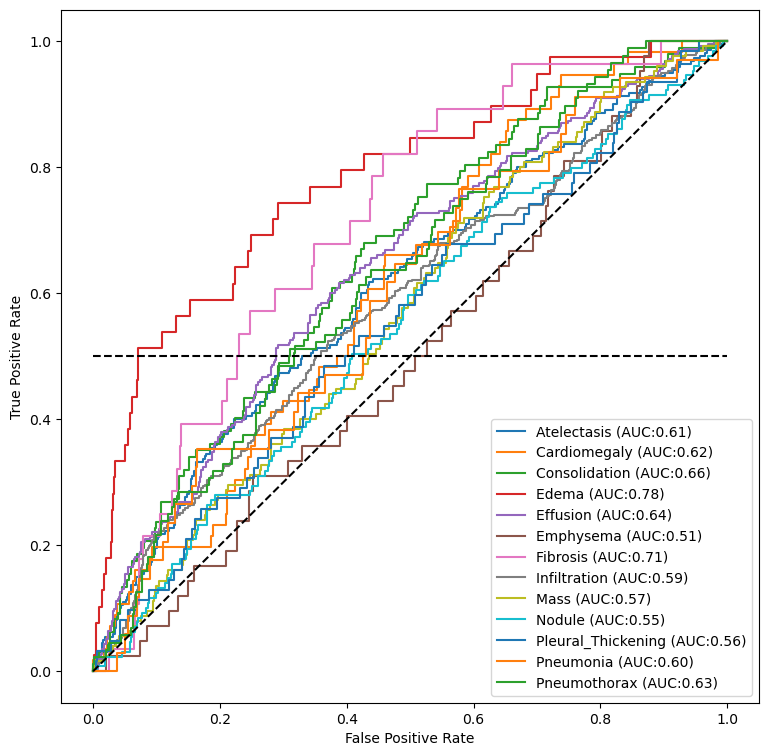

In [81]:
def plot_roc_curve(test_Y, pred_y, all_labels):
    from sklearn.metrics import roc_curve, auc
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    for (idx, c_label) in enumerate(all_labels):
        fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_y[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    # add threshold line at y=0.5
    c_ax.plot([0, 1], [0.5, 0.5], linestyle='--', color='black')
    # add black line y=x
    c_ax.plot([0, 1], [0, 1], linestyle='--', color='black')
    fig.savefig('barely_trained_net.png')

plot_roc_curve(test_Y, pred_y, all_labels)

# Continued training

In [76]:
multi_disease_model.fit(train_ds,
                                  steps_per_epoch = STEPS_PER_EPOCH,
                                  validation_data =  (test_X, test_y),
                                  epochs = 10,
                                  callbacks = [rlr, checkpoint])

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.3418 - binary_accuracy: 0.8729 - mae: 0.1989
Epoch 1: val_loss did not improve from 0.33168
100/100 [==============================] - 30s 300ms/step - loss: 0.3418 - binary_accuracy: 0.8729 - mae: 0.1989 - val_loss: 0.3333 - val_binary_accuracy: 0.8807 - val_mae: 0.1956 - lr: 0.0010
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.3317 - binary_accuracy: 0.8742 - mae: 0.1943
Epoch 2: val_loss did not improve from 0.33168
100/100 [==============================] - 29s 296ms/step - loss: 0.3317 - binary_accuracy: 0.8742 - mae: 0.1943 - val_loss: 0.3344 - val_binary_accuracy: 0.8807 - val_mae: 0.1808 - lr: 0.0010
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.3370 - binary_accuracy: 0.8729 - mae: 0.1975
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 3: val_loss did not improve from 0.33168
100/100 [==============================] - 2

32/32 [==============================] - 1s 20ms/step


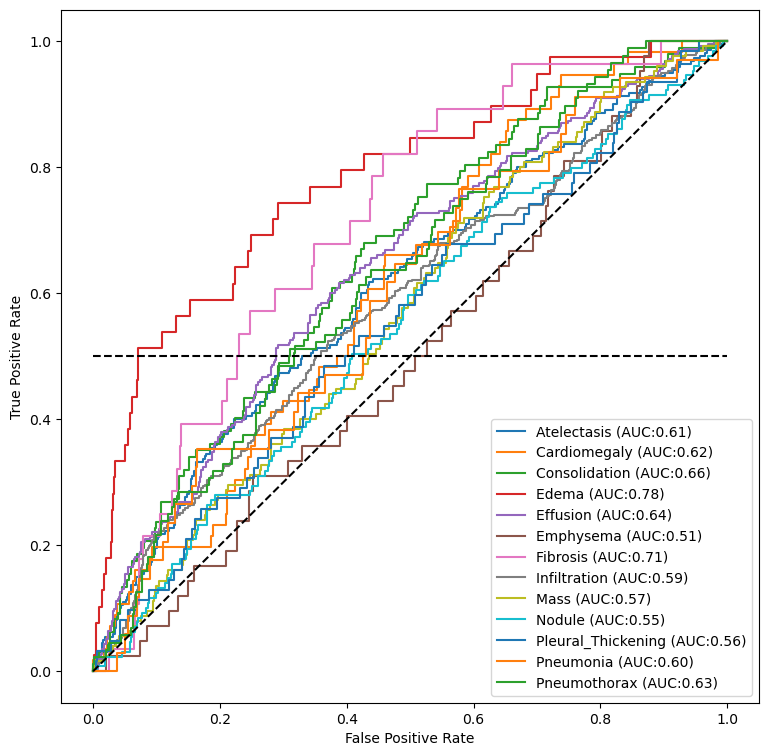

In [82]:
pred_y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)
test_Y = test_y.numpy()

plot_roc_curve(test_Y, pred_y, all_labels)

In [87]:
test_Y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [91]:
test_Y[:,0].astype(int).shape

(1000,)

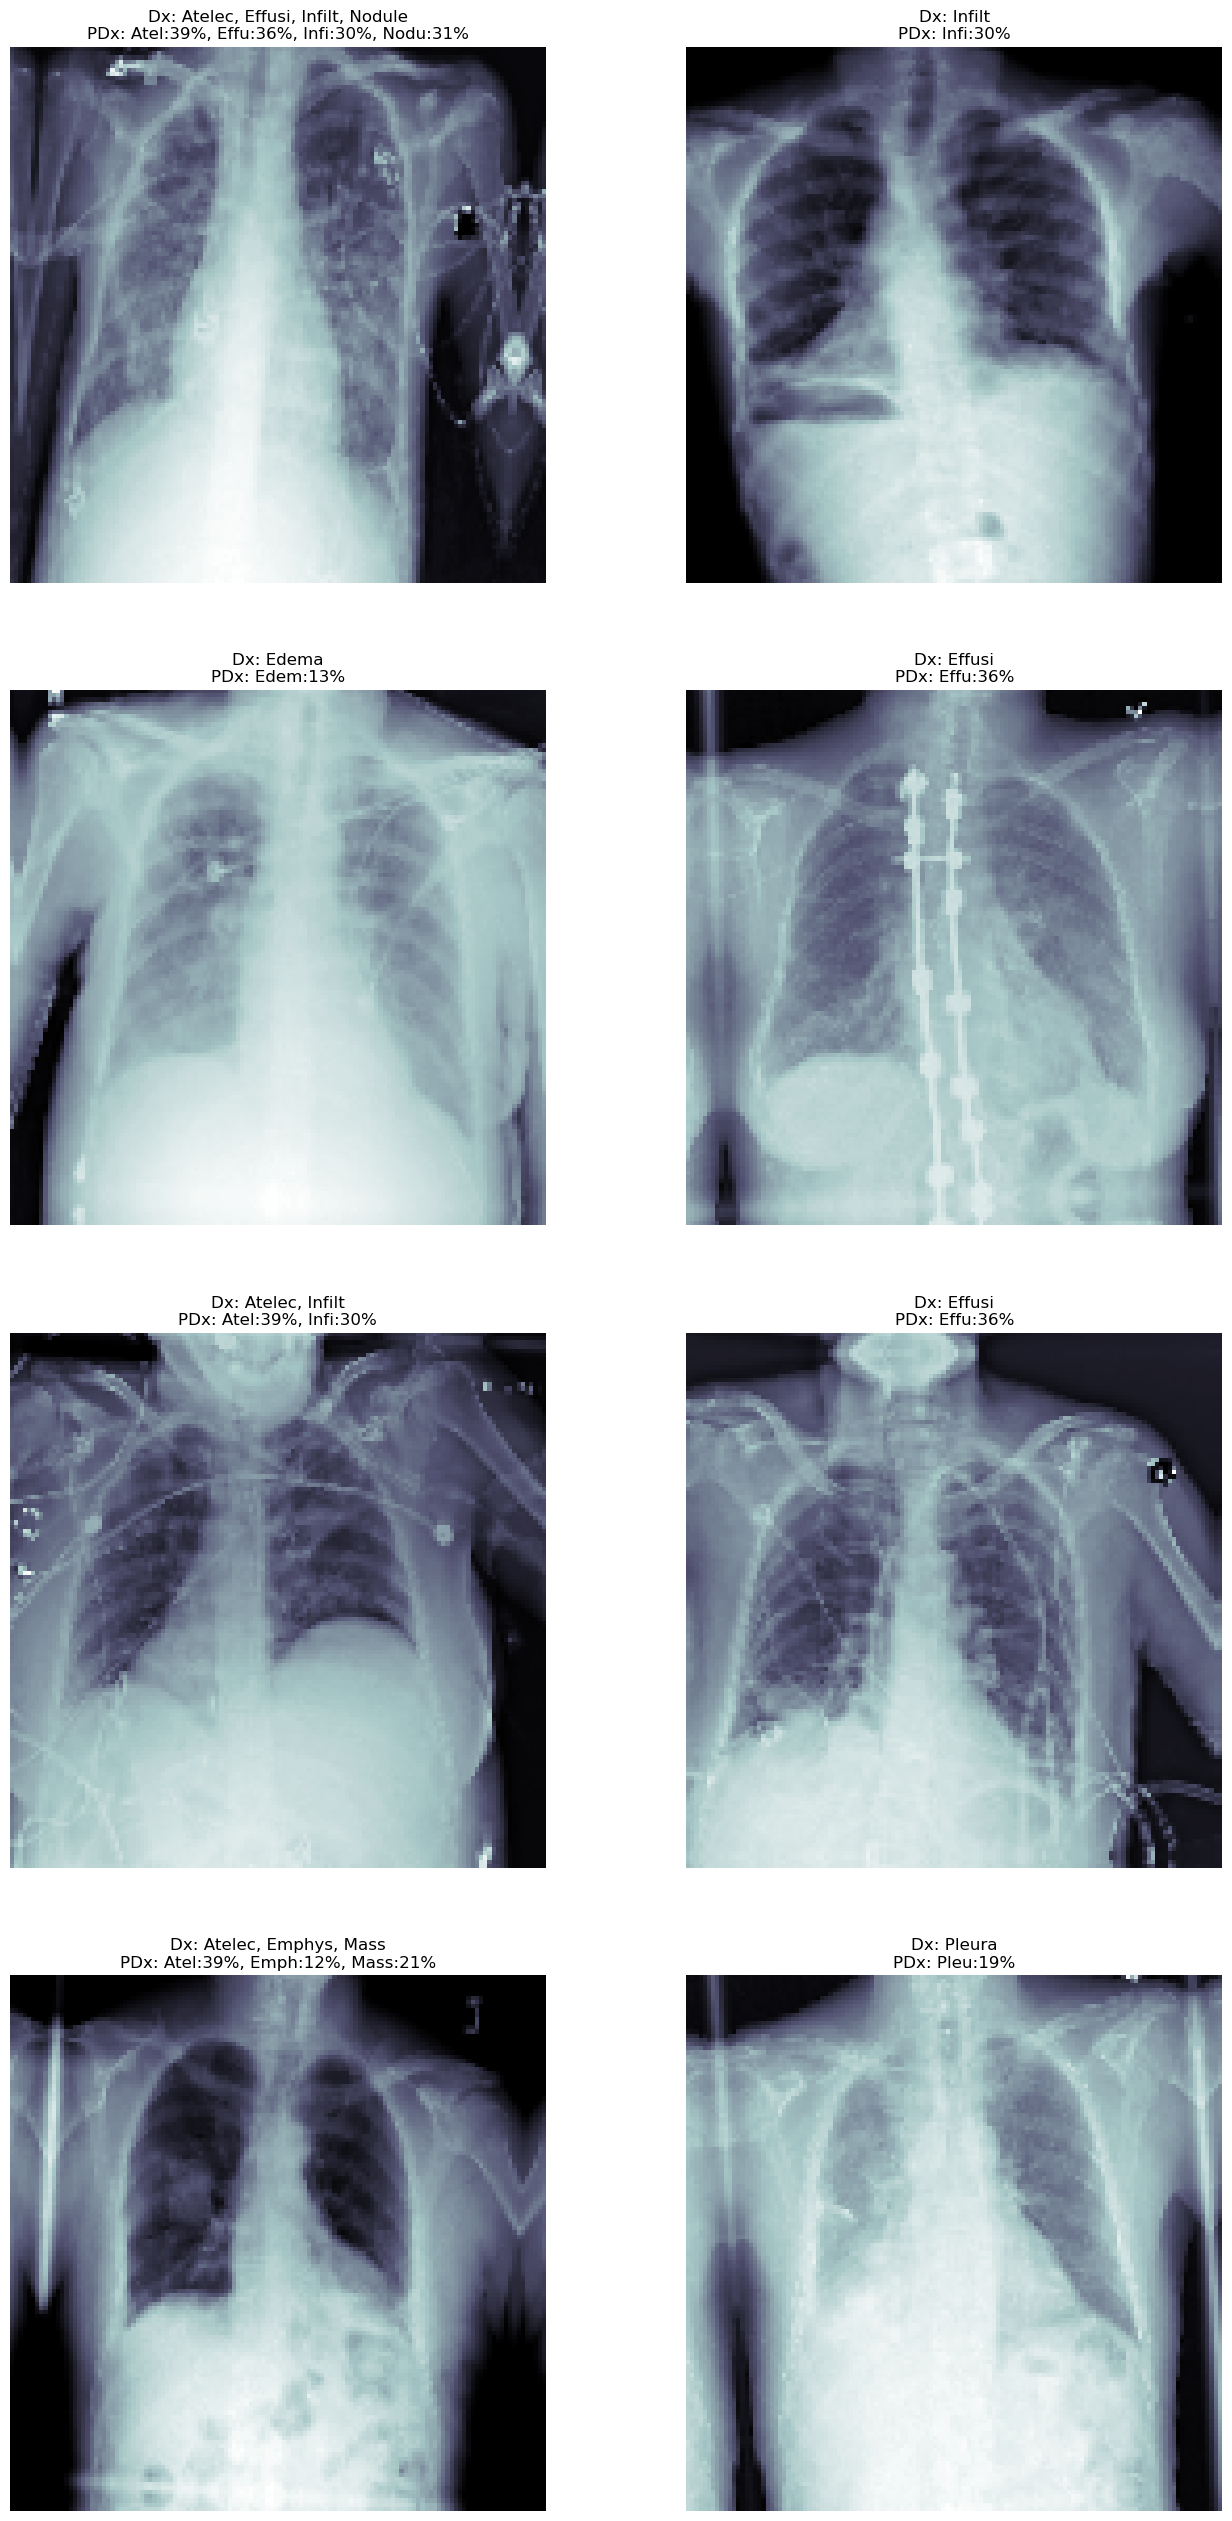

In [44]:
sickest_idx = np.argsort(np.sum(test_Y, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(all_labels,
                                                        test_Y[idx])
                if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(all_labels,
                                                                                                test_Y[idx], pred_y[idx])
                if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')

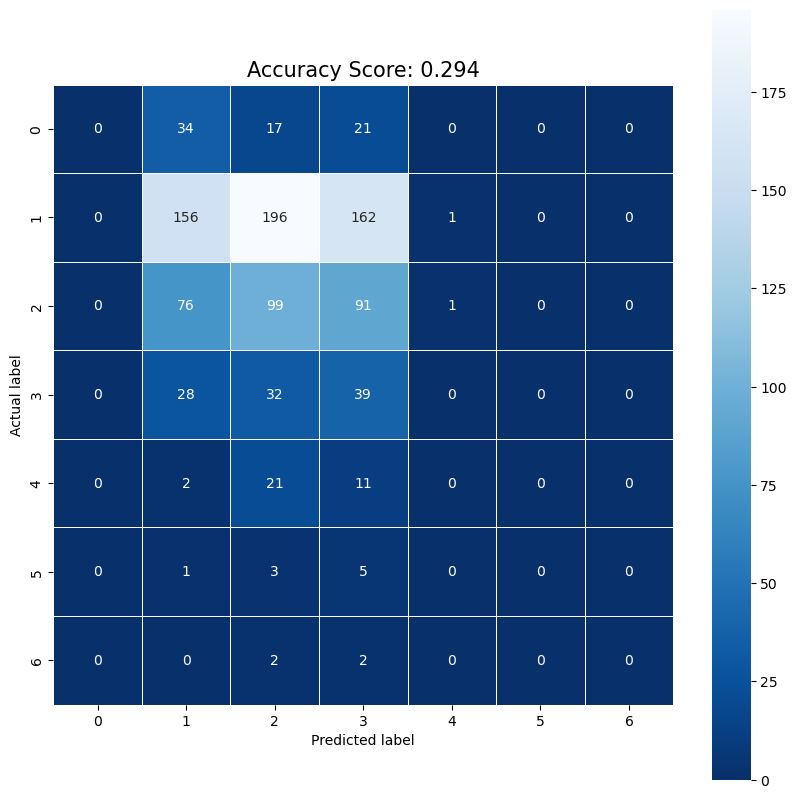

In [99]:
from sklearn.metrics import accuracy_score

sum_y_pred = np.sum(pred_y>0.25, 1)
sum_y_test = np.sum(test_Y, 1)

# plot confusion matrix with sns.heatmap
from sklearn.metrics import confusion_matrix
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(confusion_matrix(sum_y_test, sum_y_pred), annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(sum_y_test, sum_y_pred))
plt.title(all_sample_title, size = 15);
fig.savefig('trained_img_confusion_matrix.png')


